In [272]:
import math
from pprint import pprint

from matplotlib import pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from scipy.optimize import minimize
from scipy import optimize

In [135]:
eps = 0.001

In [153]:
alpha = random.random()
beta = random.random()
alpha, beta

(0.5704353905988135, 0.1916967510590799)

In [156]:
k = 100

In [159]:
arr = [alpha * (x / k) + beta + np.random.normal(0, 1) for x in range(k)]

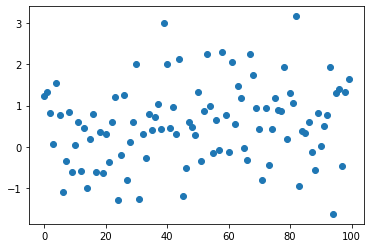

In [160]:
plt.plot(range(k), arr, 'o')
plt.show()

In [275]:
func_call = 0


def counter(func):
    def internal_counter(*x):
        global func_call
        func_call += 1
        return func(*x)

    return internal_counter


gradient_call = 0


def counter_g(func):
    def internal_counter(*x):
        global gradient_call
        gradient_call += 1
        return func(*x)

    return internal_counter


hessian_call = 0


def counter_h(func):
    def internal_counter(*x):
        global hessian_call
        hessian_call += 1
        return func(*x)

    return internal_counter

In [161]:
def lin_func(x, a, b):
    return a * x + b


def rational_func(x, a, b):
    return a / (1 + b * x)

In [163]:
def lin_func_to_optim(a, b):
    return sum([(lin_func(x / k, a, b) - arr[x]) ** 2 for x in range(k)])


def rational_func_to_optim(a, b):
    return sum([(rational_func(x / k, a, b) - arr[x]) ** 2 for x in range(k)])

In [189]:
def gradient_lin_func_with_loss(a, b):
    temp_a = []
    temp_b = []
    for ki in range(k):
        x = ki / k
        y = arr[ki]
        temp_a.append(2 * x ** 2 * a + 2 * b * x - 2 * y * x)
        temp_b.append(2 * b + 2 * a * x - 2 * y)
    da = sum(temp_a)
    db = sum(temp_b)
    return da, db


def hessian_lin_func_with_loss(a, b):
    hessian = np.array(
        [[sum([2 * (x / k) ** 2 for x in range(k)]), sum([2 * (x / k) for x in range(k)])],
         [sum([2 * (x / k) for x in range(k)]), sum([2 for x in range(k)])]]
    )
    return hessian

In [256]:
def gradient_rational_func_with_loss(a, b):
    temp_a = []
    temp_b = []
    for ki in range(k):
        x = (ki / k)
        y = (arr[ki])

        a_denominator = (1 + b * x) ** 2
        temp_a.append(
            - ((2 * x * b * y) / a_denominator)
            + (2 * a / a_denominator)
            - (2 * y / a_denominator)
        )

        temp_b.append(
            -(2 * a * x * (a - y - x * b * y))
            / ((b * x + 1) ** 3)
        )
    da = sum(temp_a)
    db = sum(temp_b)
    return da, db


def hessian_rational_func_with_loss(a, b):
    hessian = np.array(
        [[
            sum([2 / ((b * (ki / k) + 1) ** 2) for ki in range(k)]),
            sum([-(2 * (ki / k) * (2 * a - (arr[ki]) - b * (ki / k) * (arr[ki]))) / ((b * (ki / k) + 1) ** 3) for ki in
                 range(k)])
        ],
            [
                sum([-(2 * (ki / k) * (2 * a - (arr[ki]) - b * (ki / k) * (arr[ki]))) / ((b * (ki / k) + 1) ** 3) for ki
                     in range(k)]),
                sum([-(2 * (ki / k) ** 2 * a * (2 * (ki / k) * b * (arr[ki]) + 2 * (arr[ki]) - 3 * a)) / (
                        (b * (ki / k) + 1) ** 4) for ki in range(k)])
            ]
        ]
    )
    return hessian

In [268]:
def gradient_descent(a_init, b_init, eps, func_to_optim, gradient):
    a, b = a_init, b_init
    a_old, b_old = a, b
    da, db = 1, 1
    iters = 0

    while (math.fabs((func_to_optim(a, b) - func_to_optim(a_old, b_old)) / 2)) > eps or iters == 0:
        da_old, db_old = da, db
        da, db = gradient(a, b)
        if iters == 0:
            lr = 0.001
        else:
            f1 = (np.array([a, b] - np.array([a_old, b_old])))
            f2 = (np.array([da, db] - np.array([da_old, db_old])))
            lr = np.mean(np.abs(f1 * f2) / (f2 ** 2))
        a_old, b_old = a, b
        a -= lr * da
        b -= lr * db
        # print(lr, a, b, lin_func_to_optim(a, b))
        iters += 1

    return a, b, iters

In [284]:
func_call = 0
gradient_call = 0
hessian_call = 0

a_gradient_descent, b_gradient_descent, iters = gradient_descent(0, 0, eps, counter(lin_func_to_optim),
                                                                 counter_g(gradient_lin_func_with_loss))

pprint({
    "a": a_gradient_descent,
    "b": b_gradient_descent,
    "iters": iters,
    "func_call": func_call,
    "gradient_call": gradient_call,
    "hessian_call": hessian_call,
})

{'a': 0.5740122331807191,
 'b': 0.2694386829970851,
 'func_call': 20,
 'gradient_call': 9,
 'hessian_call': 0,
 'iters': 9}


In [286]:
func_call = 0
gradient_call = 0
hessian_call = 0

a_nonlinear_conjugate_gradient_descent, b_nonlinear_conjugate_gradient_descent = optimize.fmin_cg(
    lambda x: counter(lin_func_to_optim)(*x), (0, 0), fprime=lambda x: counter_g(gradient_lin_func_with_loss)(*x))

pprint({
    "a": a_nonlinear_conjugate_gradient_descent,
    "b": b_nonlinear_conjugate_gradient_descent,
    "iters": 2,
    "func_call": func_call,
    "gradient_call": gradient_call,
    "hessian_call": hessian_call,
})

Optimization terminated successfully.
         Current function value: 87.050279
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
{'a': 0.5714742681064446,
 'b': 0.2707837160538836,
 'func_call': 5,
 'gradient_call': 5,
 'hessian_call': 0,
 'iters': 2}


In [289]:
func_call = 0
gradient_call = 0
hessian_call = 0

newton_results = optimize.minimize(lambda x: counter(lin_func_to_optim)(*x), np.array([0, 0]), method='Newton-CG',
                                   jac=lambda x: counter_g(gradient_lin_func_with_loss)(*x),
                                   hess=lambda x: counter_h(hessian_lin_func_with_loss)(*x))
a_newton, b_newton = newton_results.x

pprint({
    "a": a_newton,
    "b": b_newton,
    "iters": 3,
    "func_call": func_call,
    "gradient_call": gradient_call,
    "hessian_call": hessian_call,
})

{'a': 0.5714742681064442,
 'b': 0.27078371605388385,
 'func_call': 3,
 'gradient_call': 3,
 'hessian_call': 3,
 'iters': 3}


In [292]:
func_call = 0
gradient_call = 0
hessian_call = 0


lm_res = optimize.root(lambda x: counter_g(gradient_lin_func_with_loss)(*x), np.array([0, 0]), method='lm', options={"eps": eps})
a_lm, b_lm = lm_res.x

pprint({
    "a": a_lm,
    "b": b_lm,
    "iters": 7,
    "func_call": func_call,
    "gradient_call": gradient_call,
    "hessian_call": hessian_call,
})
lm_res

{'a': 0.5714742681064442,
 'b': 0.27078371605388385,
 'func_call': 0,
 'gradient_call': 9,
 'hessian_call': 0,
 'iters': 7}


   cov_x: array([[ 0.00448299, -0.00236759],
       [-0.00236759,  0.00127047]])
    fjac: array([[-223.16137659,    0.89621243],
       [-117.8578946 ,   14.93538018]])
     fun: array([-1.33226763e-15, -7.10542736e-15])
    ipvt: array([2, 1], dtype=int32)
 message: 'The relative error between two consecutive iterates is at most 0.000000'
    nfev: 7
     qtf: array([1.02272223e-12, 3.24392471e-13])
  status: 2
 success: True
       x: array([0.57147427, 0.27078372])

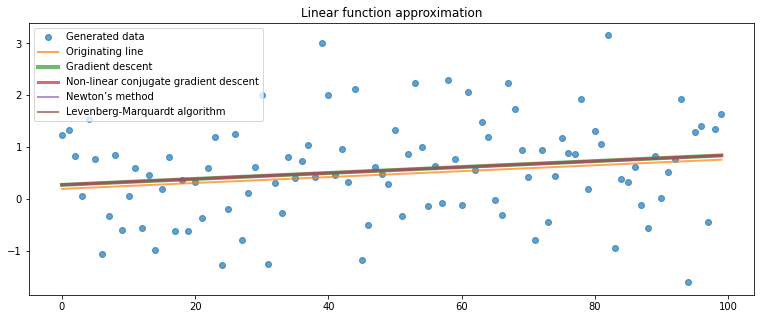

In [250]:
plt.figure(figsize=(13, 5))
plt.plot(range(k), arr, 'o', alpha=0.7, label="Generated data")
plt.plot(range(k), [lin_func(x / k, alpha, beta) for x in range(k)], linewidth=2, alpha=0.7, label="Originating line")
plt.plot(range(k), [lin_func(x / k, a_gradient_descent, b_gradient_descent) for x in range(k)], linewidth=4, alpha=0.7,
         label="Gradient descent")
plt.plot(range(k),
         [lin_func(x / k, a_nonlinear_conjugate_gradient_descent, b_nonlinear_conjugate_gradient_descent) for x in
          range(k)], linewidth=3, alpha=0.7,
         label="Non-linear conjugate gradient descent")
plt.plot(range(k), [lin_func(x / k, a_newton, b_newton) for x in range(k)], linewidth=2, alpha=0.7,
         label="Newton’s method")
plt.plot(range(k), [lin_func(x / k, a_lm, b_lm) for x in range(k)], linewidth=2, alpha=0.7,
         label="Levenberg-Marquardt algorithm")
plt.title('Linear function approximation')
plt.legend()
plt.show()

In [303]:
func_call = 0
gradient_call = 0
hessian_call = 0

a_gradient_descent_rat, b_gradient_descent_rat, iters = gradient_descent(0, 0, eps, counter(rational_func_to_optim),
                                                                  counter_g(gradient_rational_func_with_loss))

pprint({
    "a": a_gradient_descent_rat,
    "b": b_gradient_descent_rat,
    "iters": iters,
    "func_call": func_call,
    "gradient_call": gradient_call,
    "hessian_call": hessian_call,
})

{'a': 0.3810991174865162,
 'b': -0.5584409317002158,
 'func_call': 46,
 'gradient_call': 22,
 'hessian_call': 0,
 'iters': 22}


In [295]:
func_call = 0
gradient_call = 0
hessian_call = 0

a_nonlinear_conjugate_gradient_descent_rat, b_nonlinear_conjugate_gradient_descent_rat = optimize.fmin_cg(
    lambda x: counter(rational_func_to_optim)(*x), (0, 0), fprime=lambda x: counter_g(gradient_rational_func_with_loss)(*x))

pprint({
    "a": a_nonlinear_conjugate_gradient_descent_rat,
    "b": b_nonlinear_conjugate_gradient_descent_rat,
    "iters": 10,
    "func_call": func_call,
    "gradient_call": gradient_call,
    "hessian_call": hessian_call,
})

Optimization terminated successfully.
         Current function value: 87.693039
         Iterations: 10
         Function evaluations: 31
         Gradient evaluations: 31
{'a': 0.3921386751576207,
 'b': -0.5341490560371829,
 'func_call': 31,
 'gradient_call': 31,
 'hessian_call': 0,
 'iters': 10}


In [297]:
func_call = 0
gradient_call = 0
hessian_call = 0

newton_results_rat = optimize.minimize(lambda x: counter(rational_func_to_optim)(*x), np.array([0, 0]), method='Newton-CG',
                                       jac=lambda x: counter_g(gradient_rational_func_with_loss)(*x),
                                       hess=lambda x: counter_h(hessian_rational_func_with_loss)(*x))
a_newton_rat, b_newton_rat = newton_results_rat.x


pprint({
    "a": a_newton_rat,
    "b": b_newton_rat,
    "iters": 8,
    "func_call": func_call,
    "gradient_call": gradient_call,
    "hessian_call": hessian_call,
})
newton_results_rat

{'a': 0.3921386731227408,
 'b': -0.5341490602242988,
 'func_call': 13,
 'gradient_call': 13,
 'hessian_call': 8,
 'iters': 8}


     fun: 87.69303885302975
     jac: array([ 0.00040321, -0.00039821])
 message: 'Optimization terminated successfully.'
    nfev: 13
    nhev: 8
     nit: 8
    njev: 13
  status: 0
 success: True
       x: array([ 0.39213867, -0.53414906])

In [301]:
func_call = 0
gradient_call = 0
hessian_call = 0

lm_res_rat = optimize.root(lambda x: counter_g(gradient_rational_func_with_loss)(*x), np.array([0.5, -0.5]), method='lm',
                           options={"eps": eps})
a_lm_rat, b_lm_rat = lm_res_rat.x

pprint({
    "a": a_lm_rat,
    "b": b_lm_rat,
    "iters": 8,
    "func_call": func_call,
    "gradient_call": gradient_call,
    "hessian_call": hessian_call,
})
lm_res_rat

{'a': 0.39213867331202296,
 'b': -0.5341490595957724,
 'func_call': 0,
 'gradient_call': 45,
 'hessian_call': 0,
 'iters': 8}


   cov_x: array([[0.00030725, 0.00072365],
       [0.00072365, 0.00173064]])
    fjac: array([[-4.63172614e+02, -3.93884179e-01],
       [ 1.93670116e+02, -2.40378756e+01]])
     fun: array([-1.78902173e-08,  2.10885127e-08])
    ipvt: array([1, 2], dtype=int32)
 message: 'The relative error between two consecutive iterates is at most 0.000000'
    nfev: 43
     qtf: array([-1.03965746e-07,  5.18226090e-08])
  status: 2
 success: True
       x: array([ 0.39213867, -0.53414906])

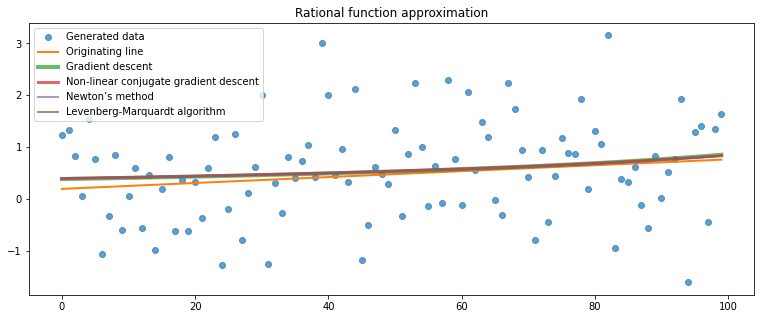

In [266]:
plt.figure(figsize=(13, 5))
plt.plot(range(k), arr, 'o', alpha=0.7, label="Generated data")
plt.plot(range(k), [lin_func(x / k, alpha, beta) for x in range(k)], linewidth=2, alpha=1, label="Originating line")
plt.plot(range(k), [rational_func(x / k, a_gradient_descent_rat, b_gradient_descent_rat) for x in range(k)],
         linewidth=4,
         alpha=0.7,
         label="Gradient descent")
plt.plot(range(k),
         [rational_func(x / k, a_nonlinear_conjugate_gradient_descent_rat, b_nonlinear_conjugate_gradient_descent_rat)
          for x in
          range(k)], linewidth=3, alpha=0.7,
         label="Non-linear conjugate gradient descent")
plt.plot(range(k), [rational_func(x / k, a_newton_rat, b_newton_rat) for x in range(k)], linewidth=2, alpha=0.7,
         label="Newton’s method")
plt.plot(range(k), [rational_func(x / k, a_lm_rat, b_lm_rat) for x in range(k)], linewidth=2, alpha=0.7,
         label="Levenberg-Marquardt algorithm")
plt.title('Rational function approximation')
plt.legend()
plt.show()